In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import random 
import os 
import pandas as pd 

from work import handler
from work import casestudy
from work import storm_tracker
from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'


hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 2.56 seconds


In [2]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)

In [3]:
# from work.ml_tools.standard_scaler_from_ds import scale_profiles
X, X_scaled, scaler_profiles = scale_profiles(ds)

In [4]:
from tensorflow import keras
latent_space_size = 16
model_name = 'ae_fully_connected_v0'+f"_latent_{latent_space_size}"
ae_name = f'{model_name}_v0.keras'
save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)

# Load the autoencoder
autoencoder = keras.models.load_model(save_path_ae)
# Print the model summary to identify layers
autoencoder.summary()

2024-11-28 19:10:28.052047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 19:10:28.078083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 19:10:28.085230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 19:10:28.105391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 19:10:29.466723: W tensorflow/compiler/tf2

Model: "ae_fully_connected_v0_latent_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 52, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 416)            │       213,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 52, 8)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,986 (6.61 MB)

 Trainable params: 577,328 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,154,658 (4.40 MB)

In [22]:
# Using the name of the bottleneck layer
encoder_output = autoencoder.get_layer('dense_3').output  # Replace 'bottleneck' with actual name

# Or, if you know the index of the bottleneck layer
# encoder_output = autoencoder.layers[n].output  # Replace n with the actual index

# Reconstruct the encoder model
encoder = keras.Model(inputs=autoencoder.input, outputs=encoder_output)
print("Autoencoder input shape:", autoencoder.input_shape)
print("X_scaled shape:", X_scaled.shape)

# Encode the data
X_latent = encoder.predict(X_scaled)
print("Latent representation shape:", X_latent.shape)

Autoencoder input shape: (None, 52, 8)
X_scaled shape: (528, 52, 8)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Latent representation shape: (528, 16)


## PCA

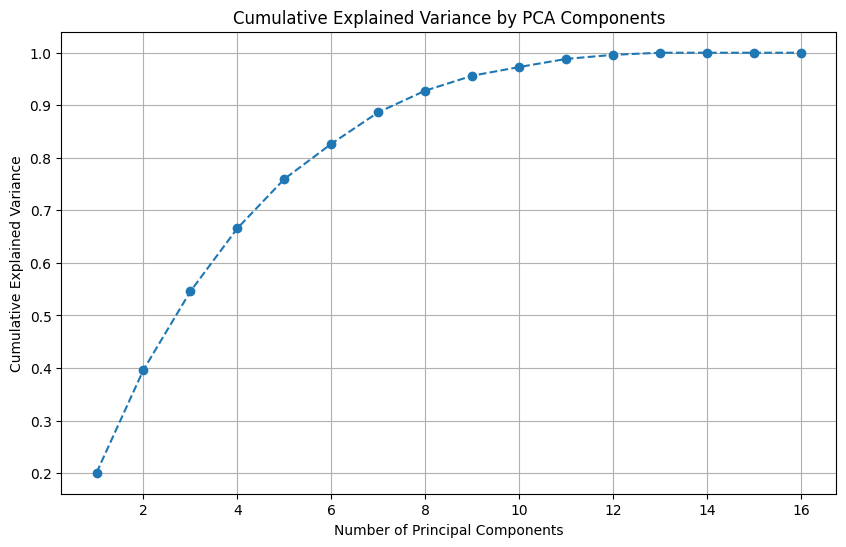

In [32]:
# Step 1: Standardize and Apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_latent_scaled = scaler.fit_transform(X_latent)

# Apply PCA to get all components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_latent_scaled)
explained_variance_ratio = pca_full.explained_variance_ratio_

# Step 2: Plot the Explained Variance Ratio
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Step 3: Decide on Number of Principal Components
n_components = 9  # Adjust based on the plot
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_latent_scaled)

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python

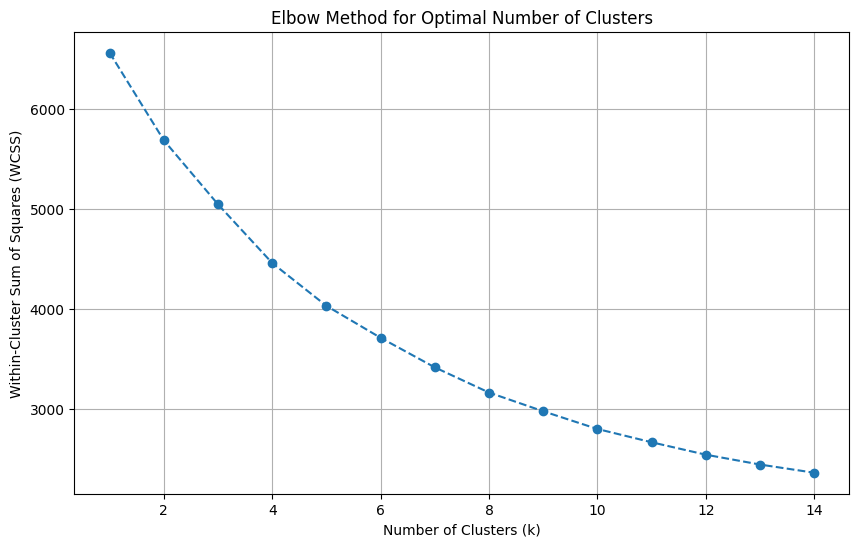

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


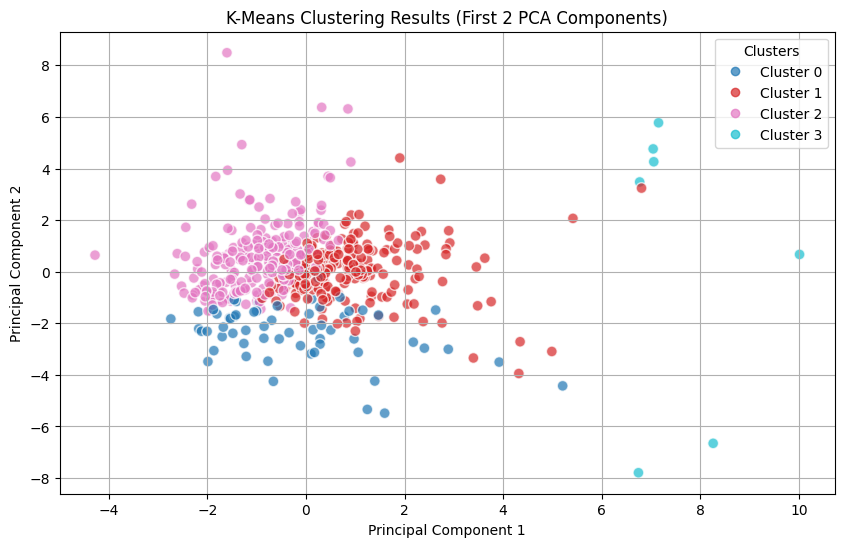

In [37]:
# Step 4: Perform K-Means Clustering and Create Elbow Plot
from sklearn.cluster import KMeans

cluster_range = range(1, 15)
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

# Step 5: Decide on Number of Clusters
optimal_k = 4  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 6: Visualize the Clusters
# Option A: 2D Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_labels,
    cmap='tab10',
    s=60,
    alpha=0.7,
    edgecolors='w'
)
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in range(optimal_k)]
plt.legend(handles, legend_labels, title="Clusters", loc='best')
plt.title('K-Means Clustering Results (First 2 PCA Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


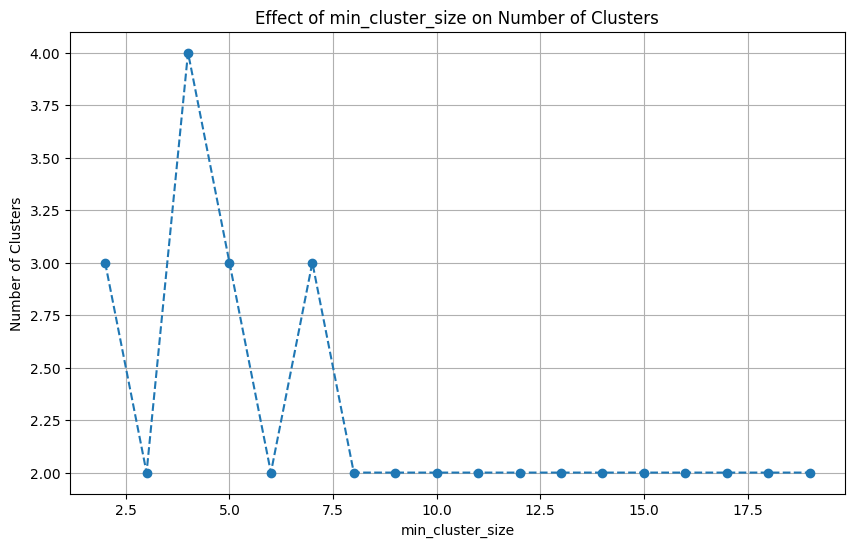

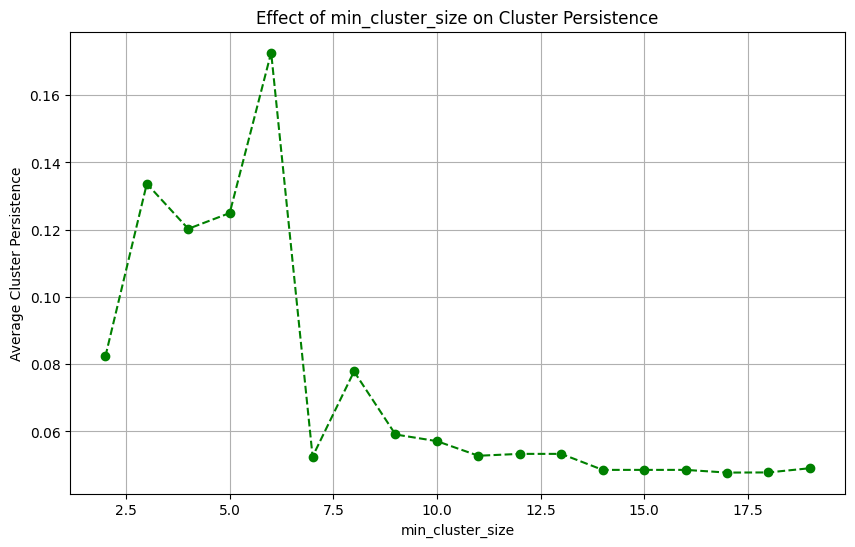

In [42]:
import hdbscan

# Initialize lists to store clustering results
min_cluster_sizes = range(2, 20)  # Adjust the range as needed
num_clusters = []
cluster_persistences = []

for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=1,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    cluster_labels = clusterer.fit_predict(X_pca)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    num_clusters.append(n_clusters)
    # Average cluster persistence (measure of cluster stability)
    cluster_persistence = np.mean(clusterer.cluster_persistence_)
    cluster_persistences.append(cluster_persistence)

# Plot number of clusters vs. min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, num_clusters, marker='o', linestyle='--')
plt.title('Effect of min_cluster_size on Number of Clusters')
plt.xlabel('min_cluster_size')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()

# Plot average cluster persistence vs. min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, cluster_persistences, marker='o', linestyle='--', color='green')
plt.title('Effect of min_cluster_size on Cluster Persistence')
plt.xlabel('min_cluster_size')
plt.ylabel('Average Cluster Persistence')
plt.grid(True)
plt.show()


Number of clusters found: 3


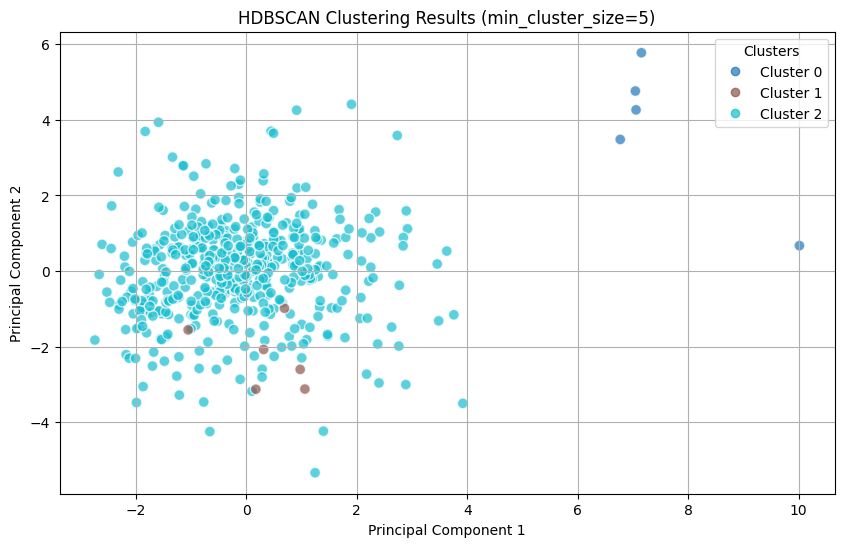

In [44]:
optimal_min_cluster_size = 5  # Adjust based on your analysis

# Perform HDBSCAN clustering with the optimal min_cluster_size
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=optimal_min_cluster_size,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(X_pca)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found: {n_clusters}")

# Option A: 2D Visualization
plt.figure(figsize=(10, 6))

# Exclude noise points (optional)
mask = cluster_labels != -1
X_plot = X_pca[mask]
labels_plot = cluster_labels[mask]

scatter = plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=labels_plot,
    cmap='tab10',
    s=60,
    alpha=0.7,
    edgecolors='w'
)

# Add legend
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in set(labels_plot)]
plt.legend(handles, legend_labels, title="Clusters", loc='best')

plt.title(f'HDBSCAN Clustering Results (min_cluster_size={optimal_min_cluster_size})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


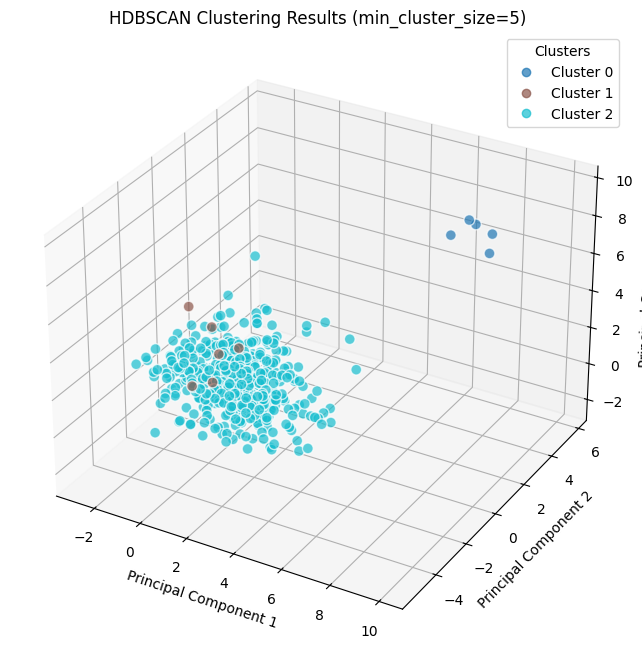

In [45]:
from mpl_toolkits.mplot3d import Axes3D

if n_components >= 3:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
        c=labels_plot,
        cmap='tab10',
        s=60,
        alpha=0.7,
        edgecolors='w'
    )

    # Add legend
    handles, _ = scatter.legend_elements()
    legend_labels = [f"Cluster {i}" for i in set(labels_plot)]
    ax.legend(handles, legend_labels, title="Clusters", loc='best')

    ax.set_title(f'HDBSCAN Clustering Results (min_cluster_size={optimal_min_cluster_size})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()


In [46]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score (excluding noise points)
if len(set(cluster_labels)) > 1 and n_clusters > 1:
    score = silhouette_score(X_pca[cluster_labels != -1], cluster_labels[cluster_labels != -1])
    print(f"Silhouette Score (excluding noise): {score:.3f}")
else:
    print("Cannot compute Silhouette Score with less than 2 clusters.")


Silhouette Score (excluding noise): 0.440
